In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set manual seed for reproducibility
torch.manual_seed(0)

# Define simple feedforward neural network
class VesselPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 6)  # [x, y, psi, u, v, r]
        )

    def forward(self, t):
        return self.net(t)

# Vessel constants
M = torch.tensor([[3980.0, 0, 0],
                  [0, 3980.0, 0],
                  [0, 0, 19703.0]], dtype=torch.float32)
D_l = torch.tensor([50.0, 200.0, 1281.0], dtype=torch.float32)
D_q = torch.tensor([135.0, 2000.0, 0.0], dtype=torch.float32)
D_c = torch.tensor([0.0, 0.0, 3224.0], dtype=torch.float32)

def R_rot(psi):
    c, s = torch.cos(psi), torch.sin(psi)
    return torch.stack([
        torch.stack([c, -s, torch.zeros_like(c)]),
        torch.stack([s, c, torch.zeros_like(c)]),
        torch.stack([torch.zeros_like(c), torch.zeros_like(c), torch.ones_like(c)])
    ])

def pinn_loss(model, t, tau):
    t.requires_grad = True
    pred = model(t)
    eta = pred[:, :3]  # [x, y, psi]
    nu = pred[:, 3:]   # [u, v, r]

    # Compute time derivatives component-wise
    eta_dot = torch.stack([
        torch.autograd.grad(eta[:, i], t, torch.ones_like(eta[:, i]), create_graph=True)[0]
        for i in range(3)
    ], dim=1)

    nu_dot = torch.stack([
        torch.autograd.grad(nu[:, i], t, torch.ones_like(nu[:, i]), create_graph=True)[0]
        for i in range(3)
    ], dim=1)

    dyn_res, kin_res = [], []
    for i in range(len(t)):
        nu_i = nu[i]
        nu_dot_i = nu_dot[i]
        psi_i = eta[i, 2]

        # Damping
        D_i = D_l + D_q * torch.abs(nu_i) + D_c * nu_i ** 2
        D_mat = torch.diag(D_i)

        # Coriolis
        C = torch.tensor([
            [0, 0, -3980.0 * nu_i[1]],
            [0, 0, 3980.0 * nu_i[0]],
            [3980.0 * nu_i[1], -3980.0 * nu_i[0], 0]
        ], dtype=torch.float32)

        # Dynamics residual
        dyn = M @ nu_dot_i + D_mat @ nu_i + C @ nu_i - tau.squeeze()
        dyn_res.append(dyn)

        # Kinematics residual
        R = R_rot(psi_i)
        kin = eta_dot[i] - (R @ nu_i)
        kin_res.append(kin)

    dyn_res = torch.stack(dyn_res)
    kin_res = torch.stack(kin_res)
    return (dyn_res ** 2).mean() + (kin_res ** 2).mean()

# Create model and optimizer
model = VesselPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

tau = torch.tensor([[500.0, 0.0, 200.0]], dtype=torch.float32)
t_train = torch.linspace(0, 50, 200).view(-1, 1)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_train, tau)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 344608.937500
Epoch 100, Loss: 2884.867676
Epoch 200, Loss: 463.443573
Epoch 300, Loss: 154.501175
Epoch 400, Loss: 68.161430
Epoch 500, Loss: 39.957489
Epoch 600, Loss: 27.016582
Epoch 700, Loss: 19.406149
Epoch 800, Loss: 14.444162
Epoch 900, Loss: 11.064988
Epoch 1000, Loss: 8.732676
Epoch 1100, Loss: 7.123319
Epoch 1200, Loss: 6.010986
Epoch 1300, Loss: 5.229654
Epoch 1400, Loss: 4.660498
Epoch 1500, Loss: 4.222875
Epoch 1600, Loss: 135.031815
Epoch 1700, Loss: 3.610508
Epoch 1800, Loss: 3.345145
Epoch 1900, Loss: 3.141878
Epoch 2000, Loss: 3.240891
Epoch 2100, Loss: 2.709093
Epoch 2200, Loss: 2.500472
Epoch 2300, Loss: 2880.075195
Epoch 2400, Loss: 2.237710
Epoch 2500, Loss: 2.021648
Epoch 2600, Loss: 1.859961
Epoch 2700, Loss: 185.226593
Epoch 2800, Loss: 1.708220
Epoch 2900, Loss: 1.500267
Epoch 3000, Loss: 1.381251
Epoch 3100, Loss: 177.911362
Epoch 3200, Loss: 1.234465
Epoch 3300, Loss: 1.126017
Epoch 3400, Loss: 1.044011
Epoch 3500, Loss: 74.653450
Epoch 3600, 

In [33]:
t_np = t_train.detach().cpu().numpy()
pred_np = model(t_train).detach().cpu().numpy()


Text(0.5, 0, 'X')

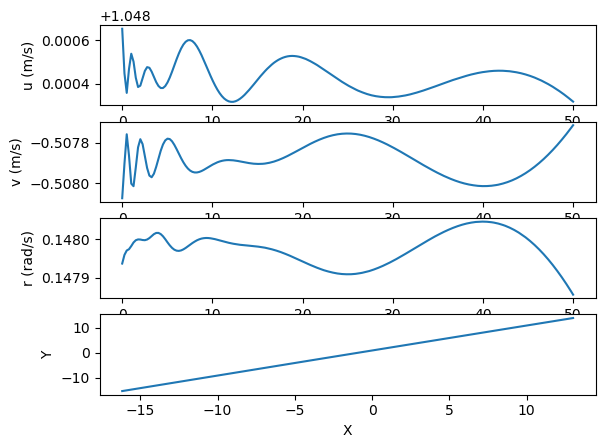

In [35]:
plt.subplot(411)
plt.plot(t_np, pred_np[:, 3])  # u
plt.ylabel('u (m/s)')

plt.subplot(412)
plt.plot(t_np, pred_np[:, 4])  # v
plt.ylabel('v (m/s)')

plt.subplot(413)
plt.plot(t_np, pred_np[:, 5])  # r
plt.ylabel('r (rad/s)')
plt.xlabel('Time (s)')

plt.subplot(414)
plt.plot(pred_np[:, 0], pred_np[:, 1])  # x,y
plt.ylabel('Y')
plt.xlabel('X')

Epoch     0 | Total Loss=8.199e-01 | RMSE=6.274e-01
Epoch   500 | Total Loss=1.558e-02 | RMSE=5.595e-01
Epoch  1000 | Total Loss=2.402e-05 | RMSE=5.568e-01
Epoch  1500 | Total Loss=1.018e-04 | RMSE=5.571e-01
Epoch  2000 | Total Loss=1.306e-05 | RMSE=5.569e-01
Epoch  2500 | Total Loss=4.129e-03 | RMSE=5.547e-01
Epoch  3000 | Total Loss=8.524e-05 | RMSE=5.568e-01
Epoch  3500 | Total Loss=2.264e-05 | RMSE=5.569e-01
Epoch  4000 | Total Loss=4.004e-04 | RMSE=5.568e-01
Epoch  4500 | Total Loss=6.185e-06 | RMSE=5.570e-01
Epoch  5000 | Total Loss=6.536e-05 | RMSE=5.556e-01
Epoch  5500 | Total Loss=1.469e-05 | RMSE=5.566e-01
Epoch  6000 | Total Loss=5.890e-07 | RMSE=5.569e-01
Epoch  6500 | Total Loss=4.451e-05 | RMSE=5.578e-01
Epoch  7000 | Total Loss=9.955e-07 | RMSE=5.570e-01
Epoch  7500 | Total Loss=8.549e-07 | RMSE=5.569e-01
Epoch  8000 | Total Loss=1.771e-06 | RMSE=5.569e-01
Epoch  8500 | Total Loss=2.695e-05 | RMSE=5.566e-01
Epoch  9000 | Total Loss=2.746e-05 | RMSE=5.567e-01
Epoch  9500 

c:\Users\adil\anaconda3\envs\ham\Lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())


L-BFGS done.


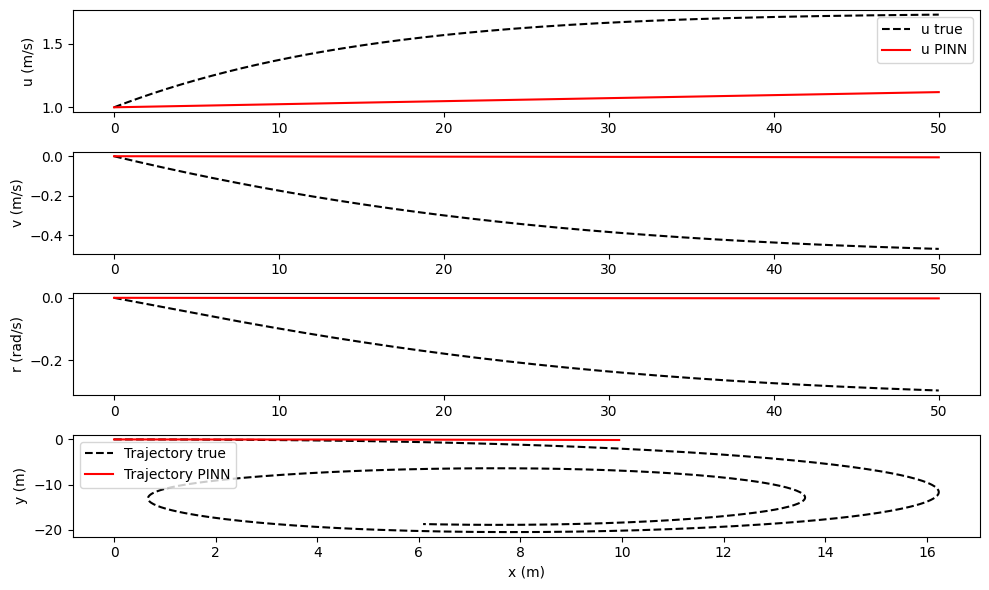

In [7]:
# ===============================================================
#  Final Stable PINN vs Numerical Integration for Vessel Dynamics
#  With normalization, stable autograd handling, and L-BFGS tuning
# ===============================================================

import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ---------------------------------------------------------------
# 1. Ship parameters (simple linear dynamics)
# ---------------------------------------------------------------
params = dict(
    Xu=-0.05, Xv=0.02, Xr=0.01, X0=0.1,
    Yu=-0.02, Yv=-0.1, Yr=0.05, Y0=0.0,
    Nu=-0.01, Nv=0.03, Nr=-0.1, N0=0.0,
)
p = params

# ---------------------------------------------------------------
# 2. True vessel dynamics (6 states)
# ---------------------------------------------------------------
def ship_dynamics(t, s):
    x, y, psi, u, v, r = s
    dx = u * np.cos(psi) - v * np.sin(psi)
    dy = u * np.sin(psi) + v * np.cos(psi)
    dpsi = r
    du = p["Xu"]*u + p["Xv"]*v + p["Xr"]*r + p["X0"]
    dv = p["Yu"]*u + p["Yv"]*v + p["Yr"]*r + p["Y0"]
    dr = p["Nu"]*u + p["Nv"]*v + p["Nr"]*r + p["N0"]
    return [dx, dy, dpsi, du, dv, dr]

# ---------------------------------------------------------------
# 3. Numerical integration (ground truth)
# ---------------------------------------------------------------
t_span = (0, 50)
t_eval = np.linspace(*t_span, 501)
s0 = [0, 0, 0, 1.0, 0.0, 0.0]
sol = solve_ivp(ship_dynamics, t_span, s0, t_eval=t_eval)

t_train = torch.tensor(t_eval, dtype=torch.float32).view(-1, 1)
t_train.requires_grad_(True)
true_sol = torch.tensor(sol.y.T, dtype=torch.float32)

# ---------------------------------------------------------------
# 4. Normalize time and outputs
# ---------------------------------------------------------------
t_max = t_train.max()
t_norm = t_train / t_max
y_scale = true_sol.abs().max(0)[0]
y_scale[y_scale == 0] = 1.0
true_norm = true_sol / y_scale

# ---------------------------------------------------------------
# 5. Neural Network Model
# ---------------------------------------------------------------
class VesselPINN(nn.Module):
    def __init__(self, hidden=128, layers=5):
        super().__init__()
        layers_list = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 2):
            layers_list += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers_list += [nn.Linear(hidden, 6)]
        self.net = nn.Sequential(*layers_list)

    def forward(self, t):
        return self.net(t)

model = VesselPINN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# ---------------------------------------------------------------
# 6. Physics residuals (PINN constraint)
# ---------------------------------------------------------------
def pinn_residuals(model, t):
    s = model(t)
    x, y, psi, u, v, r = [s[:, i] for i in range(6)]

    # compute ds/dt efficiently
    dsdt = []
    for i in range(s.shape[1]):
        dsdt_i = autograd.grad(
            s[:, i].sum(), t, create_graph=True, retain_graph=True
        )[0]
        dsdt.append(dsdt_i)
    dsdt = torch.cat(dsdt, dim=1)
    dx, dy, dpsi, du, dv, dr = [dsdt[:, i] for i in range(6)]

    # residuals from physical equations
    res_dx = dx - (u * torch.cos(psi) - v * torch.sin(psi))
    res_dy = dy - (u * torch.sin(psi) + v * torch.cos(psi))
    res_dpsi = dpsi - r
    res_du = du - (p["Xu"]*u + p["Xv"]*v + p["Xr"]*r + p["X0"])
    res_dv = dv - (p["Yu"]*u + p["Yv"]*v + p["Yr"]*r + p["Y0"])
    res_dr = dr - (p["Nu"]*u + p["Nv"]*v + p["Nr"]*r + p["N0"])
    return res_dx, res_dy, res_dpsi, res_du, res_dv, res_dr

# ---------------------------------------------------------------
# 7. Training loop
# ---------------------------------------------------------------
epochs = 10000
for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)

    s_pred = model(t_norm)
    s0_pred = model(torch.zeros(1, 1))
    s0_true = torch.tensor(s0, dtype=torch.float32) / y_scale

    ic_loss = ((s0_pred - s0_true) ** 2).mean()
    residuals = pinn_residuals(model, t_norm)
    phys_loss = sum([(r ** 2).mean() for r in residuals])

    # adaptive weighting
    w_phys = 5.0 if epoch < 5000 else 1.0
    loss = w_phys * phys_loss + 10 * ic_loss

    # backward pass (keep graph alive for multiple derivatives)
    loss.backward(retain_graph=True)
    opt.step()

    if epoch % 500 == 0:
        with torch.no_grad():
            pred = model(t_norm)
            rmse = ((pred - true_norm) ** 2).mean().sqrt().item()
        print(f"Epoch {epoch:5d} | Total Loss={loss.item():.3e} | RMSE={rmse:.3e}")

# ---------------------------------------------------------------
# 8. Optional L-BFGS refinement
# ---------------------------------------------------------------
print("Switching to L-BFGS refinement...")

def closure():
    opt_lbfgs.zero_grad(set_to_none=True)
    s_pred = model(t_norm)
    s0_pred = model(torch.zeros(1, 1))
    s0_true = torch.tensor(s0, dtype=torch.float32) / y_scale
    ic_loss = ((s0_pred - s0_true) ** 2).mean()
    residuals = pinn_residuals(model, t_norm)
    phys_loss = sum([(r ** 2).mean() for r in residuals])
    loss = phys_loss + 10 * ic_loss
    loss.backward(retain_graph=True)
    return loss

opt_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=500, tolerance_grad=1e-9)
opt_lbfgs.step(closure)
print("L-BFGS done.")

# ---------------------------------------------------------------
# 9. Compare results
# ---------------------------------------------------------------
with torch.no_grad():
    pred_norm = model(t_norm)
    pred = pred_norm * y_scale
true = true_sol.numpy()
pred_np = pred.numpy()
t_np = t_eval

plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(t_np, true[:, 3], "k--", label="u true")
plt.plot(t_np, pred_np[:, 3], "r", label="u PINN")
plt.ylabel("u (m/s)"); plt.legend()

plt.subplot(412)
plt.plot(t_np, true[:, 4], "k--", label="v true")
plt.plot(t_np, pred_np[:, 4], "r", label="v PINN")
plt.ylabel("v (m/s)")

plt.subplot(413)
plt.plot(t_np, true[:, 5], "k--", label="r true")
plt.plot(t_np, pred_np[:, 5], "r", label="r PINN")
plt.ylabel("r (rad/s)")

plt.subplot(414)
plt.plot(true[:, 0], true[:, 1], "k--", label="Trajectory true")
plt.plot(pred_np[:, 0], pred_np[:, 1], "r", label="Trajectory PINN")
plt.xlabel("x (m)"); plt.ylabel("y (m)"); plt.legend()

plt.tight_layout()
plt.show()
